# Lab 2

grupo
1. Diego Cordova 20212
2. Paola Contreras 20213
3. Paola de León 20361

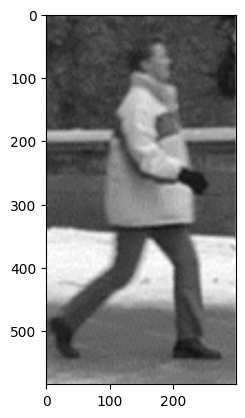

In [20]:
import matplotlib.pyplot as plt
import skimage as ski
import cv2 as cv
import numpy as np

def read_img(filepath):
    data = open(filepath, 'rb')
    img = plt.imread(data)
    return img

img = read_img('./person.png')
plt.imshow(img)

### 1. Implementar una funcion en Python que acepte una imagen a colores, y haga las siguientes transformaciones:
- conversion de RGB a escala de grises
- reescalado (resize) a un tamano (128k, 64k), (ratio 2:1).

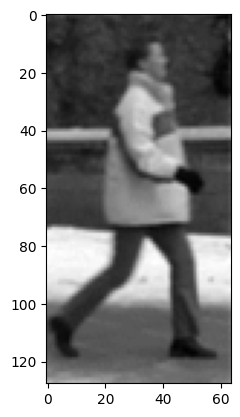

In [21]:
def parte1(img, k):
    '''
    funcion en Python que acepte una imagen a colores, y haga las siguientes transformaciones:
    - conversion de RGB a escala de grises
    - reescalado (resize) a un tamano (128k, 64k), (ratio 2:1).
    '''
    if k < 1 or k is None:
        raise Exception('K must be >= 1')

    # grayscale
    # gray_img = ski.color.rgb2gray(img)
    gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # resize
    resized_img = ski.transform.resize(gray_img, (128 * k, 64 * k))
    return resized_img
  
resized = parte1(img, 1)
plt.imshow(resized, cmap='gray')

### 2. Implementar una funci´on en Python que calcule la magnitud del y angulo del gradiente de una imagen en escala de grises. 
Internamente su algoritmo debe calcular las correlaciones Gx y Gy de la imagen con los filtros de Prewitt

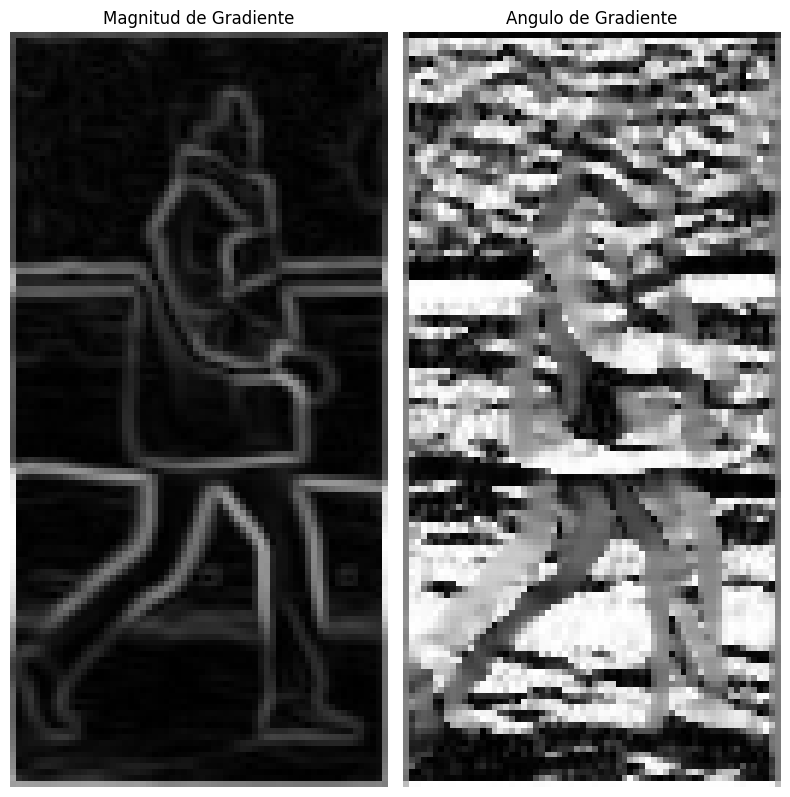

In [22]:
prewittX = np.array([
  [-1, -1, -1 ],
  [ 0,  0,  0 ],
  [ 1,  1,  1 ],
])

prewittY = np.array([
  [-1,  0, 1 ],
  [-1,  0, 1 ],
  [-1,  0, 1 ],
])

def apply_filter(I, filter):
    rows, cols = I.shape
    f_i, f_j = filter.shape

    result = np.zeros_like(I)
    padded_image = np.pad(I, ((1, 1), (1, 1)), mode='constant')

    for i in range(rows):
        for j in range(cols):
            region = padded_image[i:i+f_i, j:j+f_j]
            result[i, j] = np.sum(region * filter)

    return result

def gradient_magnitude_and_angle(image):
    Gx = apply_filter(image, prewittX)
    Gy = apply_filter(image, prewittY)

    # Magnitud
    magnitude = np.sqrt(np.square(Gx) + np.square(Gy))

    # Angulo
    angle = np.arctan2(-Gy, Gx)
    angle = np.absolute(angle) * 180 / np.pi

    return magnitude, angle

magnitude, angle = gradient_magnitude_and_angle(resized)

fig, axes = plt.subplots(1, 2, figsize=(8, 8), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(magnitude, cmap='gray')
ax[0].set_title('Magnitud de Gradiente')
ax[0].axis('off')

ax[1].imshow(angle, cmap='gray')
ax[1].set_title('Angulo de Gradiente')
ax[1].axis('off')

fig.tight_layout()
plt.show()

### 3. Implementar una funcion en Python que construya el stack de bloques de tamaño block size × block size
usando un stride de block size//2. En este caso, block size debe ser un par´ametro indicado por el usuario (se sugiere que sea un
m´ultiplo de 4, e.g. 4 × 4, 8 × 8, 16 × 16).

La entrada de la funci´on debe ser la imagen μ y θ obtenidas del gradiente, y su funci´on debe devolver dos stack o numpy
arrays de tama˜no M N ×block size × block size, uno para la magnitud y otros para el ´angulo del gradiente. Aqu´ı

In [23]:
def build_stack(magnitude, angle, block_size):
    rows, cols = magnitude.shape
    stride = block_size // 2
    M = rows // stride - 1
    N = cols // stride - 1
    print('> M:', M)
    print('> M:', N)
    print('> MxN:', M*N)

    # Inicializar los stacks de bloques
    magnitude_stack = np.zeros((M * N, block_size, block_size))
    angle_stack = np.zeros((M * N, block_size, block_size))

    # Construir los stacks de bloques
    block_index = 0
    for i in range(0, rows - block_size + 1, stride):
        for j in range(0, cols - block_size + 1, stride):
            magnitude_block = magnitude[i:i+block_size, j:j+block_size]
            angle_block = angle[i:i+block_size, j:j+block_size]
            magnitude_stack[block_index] = magnitude_block
            angle_stack[block_index] = angle_block
            block_index += 1

    return magnitude_stack, angle_stack, M, N

magnitude_stack, angle_stack, M, N = build_stack(magnitude, angle, 8)

print(magnitude_stack.shape)
print(angle_stack.shape)

> M: 31
> M: 15
> MxN: 465
(465, 8, 8)
(465, 8, 8)


### 4. Implementar una funcion en Python que construya el histograma de gradientes, a partir de los stacks de bloques μ y θ.
La construcci´on del histograma debe recibir un n´umero de bines n indicado por el usuario (se sugiere usar n = 9). Internamente
la funci´on deber´a calcular los centros de cada bin, y hacer un barrido de cada uno de los bloques en los stacks. Para cada
bloque, debe calcularse un vector (numpy array de tama˜no n) donde se guardar´a la informaci´on de su respectivo histograma.

La salida de la funci´on debe ser un numpy array H de tama˜no M N × n con la informaci´on de los cada histograma. Los
histogramas deber´an normalizarse utilizando la norma euclideana:

In [24]:
def build_gradient_histogram(magnitude_stack, angle_stack, n=9, epsilon=1e-10, M=0, N=0):
    # Calcular los bordes de cada bin
    bin_edges = np.linspace(0, 180, n + 1)
    # bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Inicializar el array H
    print("M", M)
    print("N", N)
    H = np.zeros((M * N, n))
    
    # Iterar sobre cada bloque en los stacks
    for i in range(M):
        for j in range(N):
            # Obtener el bloque de magnitud y ángulo
            magnitude_block = magnitude_stack[i * j]
            angle_block = angle_stack[i * j]
            
            # Calcular el histograma para el bloque
            histogram = np.histogram(angle_block, bins=bin_edges, weights=magnitude_block, density=False)[0]
            
            # Normalizar el histograma
            norm = np.linalg.norm(histogram) + epsilon
            H[i * N + j] = histogram / norm
    
    return H

H = build_gradient_histogram(magnitude_stack, angle_stack, n=9, M=M, N=N)
H.shape


M 31
N 15


(465, 9)

### 5. Escribir una función en python que a cada bloque en el stack, convierta el histograma de ese bloque a un representaci´on visual.

Esta representaci´on visual ser´a una matriz de tama˜no block size × block size. Esta imagen se trabaja como una
imagen con fondo negro. Por cada ´ındice en el histograma de dicho bloque, i = 1, 2, . . . , n, se dibujar´a una l´ınea con ´angulo
en el centroide Ci del bin i, y de magnitud o intensidad igual al valor del histograma en el bin i.

Construir una imagen de direcciones que dibuje los histogramas visuales de cada bloque

In [28]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def histogram_to_visual_representation(histogram, block_size):
    # Calcular los centros de cada bin
    bin_centers = np.linspace(0, 180, len(histogram))
    
    # Crear una imagen de fondo negro
    visual_representation = np.zeros((block_size, block_size), dtype=np.uint8)
    
    # Calcular el centro del bloque
    center_x, center_y = block_size // 2, block_size // 2
    
    # Dibujar una línea para cada bin del histograma
    for i in range(len(histogram)):
        # Calcular el ángulo en radianes
        angle_rad = np.deg2rad(bin_centers[i])

        # Calcular la magnitud de la línea
        magnitude = int(histogram[i] * block_size / 2)

        # Calcular los puntos de inicio y fin de la línea
        start_x = int(center_x - magnitude * np.cos(angle_rad))
        start_y = int(center_y - magnitude * np.sin(angle_rad))
        end_x = int(center_x + magnitude * np.cos(angle_rad))
        end_y = int(center_y + magnitude * np.sin(angle_rad))

        # Dibujar la línea en la imagen
        cv2.line(visual_representation, (start_x, start_y), (end_x, end_y), 255, 1)
    
    return visual_representation

In [39]:
from PIL import Image
def completePiPeline(filepath, k, block_size, n):
    img = read_img(filepath)
    resized = parte1(img, k)
    magnitude, angle = gradient_magnitude_and_angle(resized)
    magnitude_stack, angle_stack, M, N = build_stack(magnitude, angle, block_size)
    H = build_gradient_histogram(magnitude_stack, angle_stack, n=n, M=M, N=N)
    
    visual_HOG = [histogram_to_visual_representation(H[i], block_size) for i in range(H.shape[0])]

    visual_grid = (resized.shape[0]//block_size, resized.shape[1]//block_size)
    visual_grid_y, visual_grid_x = visual_grid

    # fig, axs = plt.subplots(visual_grid_y, visual_grid_x, figsize=(visual_grid_x, visual_grid_y), squeeze=False, gridspec_kw={'hspace': 0, 'wspace': 0})
    # hog_counter = 0

    # for i in range(visual_grid_y):
    #     for j in range(visual_grid_x):
    #         axs[i, j].imshow(visual_HOG[hog_counter], cmap='gray')
    #         axs[i, j].axis('off')
    #         hog_counter += 1
            
    # plt.show()

    # Calculate the size of the final image
    final_height = visual_grid_y * block_size
    final_width = visual_grid_x * block_size

    # Create a blank image to render visual HOG
    visual_image = Image.new('L', (final_width, final_height))

    hog_counter = 0
    for i in range(visual_grid_y):
        for j in range(visual_grid_x):
            # Convert the visual HOG to a PIL image
            hog_image = Image.fromarray(visual_HOG[hog_counter])

            # Paste the HOG image into the final image
            visual_image.paste(hog_image, (j * block_size, i * block_size))

            hog_counter += 1

    plt.imshow(visual_image)
    plt.show()

> M: 31
> M: 15
> MxN: 465
M 31
N 15


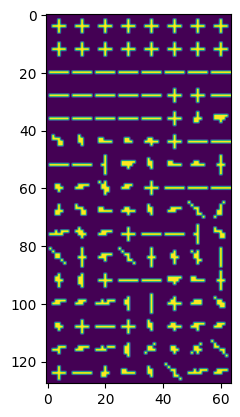

In [48]:
completePiPeline('./person.png', 1, 8, 9)

### 6

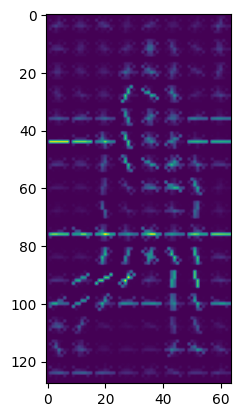

In [47]:
from skimage.feature import hog
I = read_img('./person.png')
I = parte1(I, 1)
fd, hogI = hog(I, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
plt.figure()
plt.imshow(hogI)
plt.show()